In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import *
import cv2
import numpy as np
import random
import os
import pandas as pd
import warnings
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, UpSampling2D,
    Concatenate, Activation, Multiply, Reshape,
    GlobalAveragePooling2D, Dense, AveragePooling2D, Lambda, BatchNormalization
)
from tensorflow.keras.models import Model

C:\Users\NITK\anaconda3\envs\Shyam_Lal\lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [ ]:
import tensorflow as tf

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    vertical_flip=True
)

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

train_generator = train_datagen.flow_from_directory(
    directory=r"D:\Akshaya\Resampled prostate images with reduced images - Copy\train",
    target_size=(224, 224),
    batch_size=16,
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    directory=r"D:\Akshaya\Resampled prostate images with reduced images - Copy\Valid",
    target_size=(224, 224),
    batch_size=16,
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    directory=r"D:\Akshaya\Resampled prostate images with reduced images - Copy\test",
    target_size=(224, 224),
    batch_size=16,
    shuffle=False  
)

print("Train classes:", train_generator.class_indices)
print("Validation classes:", val_generator.class_indices)
print("Test classes:", test_generator.class_indices)


Found 11684 images belonging to 4 classes.
Found 2939 images belonging to 4 classes.
Found 2854 images belonging to 4 classes.
Train classes: {'0': 0, '1': 1, '2': 2, '3': 3}
Validation classes: {'0': 0, '1': 1, '2': 2, '3': 3}
Test classes: {'0': 0, '1': 1, '2': 2, '3': 3}


In [ ]:

def scr(x):
    C = x.shape[-1]
    y = Conv2D(C, (3,3), padding='same', activation='relu')(x)

    c_half = C // 2
    x1, x2 = Lambda(lambda z: tf.split(z, [c_half, C - c_half], axis=-1))(x)
    y1, y2 = Lambda(lambda z: tf.split(z, [c_half, C - c_half], axis=-1))(y)

    x_concat = Concatenate()([x1, y2])
    y_concat = Concatenate()([y1, x2])

    x_sc = Conv2D(C, (3,3), padding='same')(x_concat)
    x_sc = BatchNormalization()(x_sc)
    x_sc = Activation('relu')(x_sc)

    y_sc = Conv2D(C, (3,3), padding='same')(y_concat)
    y_sc = BatchNormalization()(y_sc)
    y_sc = Activation('relu')(y_sc)

    x_int = GlobalAveragePooling2D()(x_sc)
    x_int = Dense(C, activation='sigmoid')(x_int)
    x_int = Reshape((1,1,C))(x_int)
    x_out = Multiply()([x_int, x_sc])

    y_int = GlobalAveragePooling2D()(y_sc)
    y_int = Dense(C, activation='sigmoid')(y_int)
    y_int = Reshape((1,1,C))(y_int)
    y_out = Multiply()([y_int, y_sc])

    out = Add()([x_out, y_out, x])
    return out
def fcn(x, num_classes=4):
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(num_classes, activation='softmax')(x)
    return output



def RCCGnet(input_shape=(1024,1024,3), num_classes=4):
    input_layer = Input(shape=input_shape)

    x = Conv2D(16, (3,3), strides=(2,2), padding='same', activation='relu')(input_layer)
    x=scr(x)
    x=scr(x)
    x = Conv2D(32, (3,3), strides=(2,2), padding='same', activation='relu')(x)
    x=scr(x)
    x=scr(x)
    x = Conv2D(64, (3,3), strides=(2,2), padding='same', activation='relu')(x)
    x=scr(x)
    x=scr(x)
    output = fcn(x, num_classes=4)
    
    model =Model(inputs=input_layer, outputs=output)
    return model

model = RCCGnet()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1024, 1024,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 16) 2320        conv2d[0][0]                     
__________________________________________________________________________________________________
lambda (Lambda)                 [(None, 512, 512, 8) 0           conv2d[0][0]                     
______________________________________________________________________________________________

In [ ]:
from tensorflow.keras.optimizers import Adam

opt = Adam(learning_rate=0.001)
model.compile(
    loss='categorical_crossentropy',
    optimizer=opt,
    metrics=['accuracy']
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',
    mode='max',
    factor=0.5,
    patience=5,
    verbose=1,
    min_delta=0.0001
)


early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.0001,
    patience=30,
    verbose=1,
    mode='max',
    restore_best_weights=True
)


check_path = '/content/drive/MyDrive/rccgnet2 d2.weights.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    check_path,
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    save_weights_only=True,
    mode='max'
)


hist_scratch =model.fit(
    train_generator,
    validation_data=val_generator,  
    epochs=65,
    verbose=1,
    callbacks=[reduce_lr, early_stop, checkpoint]
)


Epoch 1/65
731/731 [==============================] - 39s 46ms/step - loss: 0.8361 - accuracy: 0.6318 - val_loss: 0.9493 - val_accuracy: 0.5682

Epoch 00001: val_accuracy improved from -inf to 0.56822, saving model to /content/drive/MyDrive\rccgnet2 d2.weights.h5
Epoch 2/65
731/731 [==============================] - 33s 45ms/step - loss: 0.6498 - accuracy: 0.7004 - val_loss: 0.6890 - val_accuracy: 0.6945

Epoch 00002: val_accuracy improved from 0.56822 to 0.69445, saving model to /content/drive/MyDrive\rccgnet2 d2.weights.h5
Epoch 3/65
731/731 [==============================] - 33s 45ms/step - loss: 0.5857 - accuracy: 0.7270 - val_loss: 1.4630 - val_accuracy: 0.5151

Epoch 00003: val_accuracy did not improve from 0.69445
Epoch 4/65
731/731 [==============================] - 33s 45ms/step - loss: 0.5363 - accuracy: 0.7467 - val_loss: 1.0368 - val_accuracy: 0.6526

Epoch 00004: val_accuracy did not improve from 0.69445
Epoch 5/65
731/731 [==============================] - 34s 47ms/step -

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


Text(0, 0.5, 'Loss')

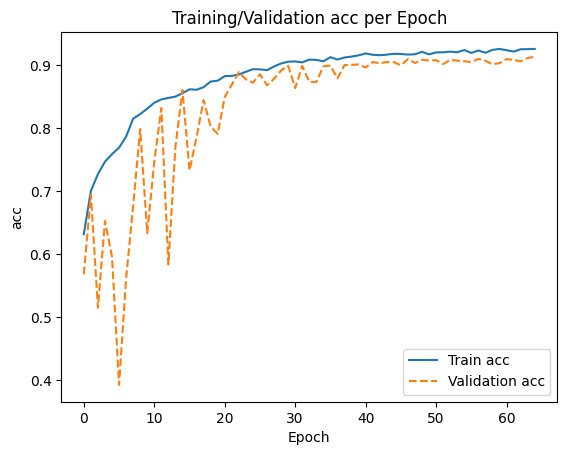

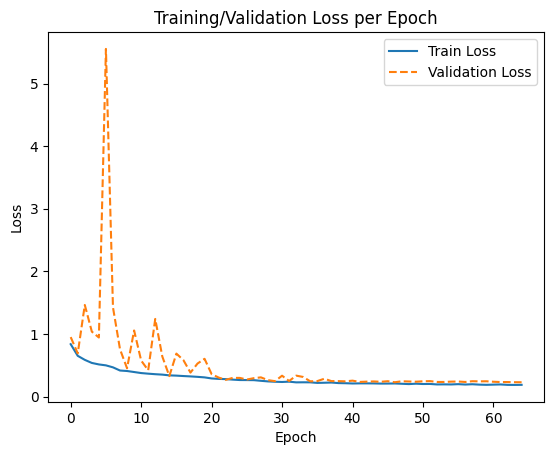

In [ ]:
print(hist_scratch.history.keys())

import matplotlib.pyplot as plt
f, ax = plt.subplots()
ax.plot(hist_scratch.history['accuracy'])
ax.plot(hist_scratch.history['val_accuracy'], '--')
ax.legend(['Train acc', 'Validation acc'])
ax.set_title('Training/Validation acc per Epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('acc')

import matplotlib.pyplot as plt
f, ax = plt.subplots()
ax.plot(hist_scratch.history['loss'], )
ax.plot(hist_scratch.history['val_loss'], '--')
ax.legend(['Train Loss', 'Validation Loss'])
ax.set_title('Training/Validation Loss per Epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')

In [6]:
# vgg16model.load_weights("./cropModel.h5")
class_labels = test_generator.class_indices
oriningal_test_classes = test_generator.labels
print(class_labels)
print("Original test classes")
print(oriningal_test_classes)

Y_pred =model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
print("Predicted test classes")
print(y_pred)

{'0': 0, '1': 1, '2': 2, '3': 3}
Original test classes
[0 0 0 ... 3 3 3]
Predicted test classes
[0 0 0 ... 3 3 3]


In [7]:
print('Accuracy {}'.format(accuracy_score(y_true=test_generator.labels, y_pred=y_pred)))
print('F1 {}'.format(f1_score(y_true=test_generator.labels, y_pred=y_pred,average = "macro")))
print('precision {}'.format(precision_score(y_true=test_generator.labels, y_pred=y_pred,average = "macro")))
print('recall {}'.format(recall_score(y_true=test_generator.labels, y_pred=y_pred,average = "macro")))

print('jaccard {}'.format(jaccard_score(y_true=test_generator.labels, y_pred=y_pred,average = "macro")))
print('classification_report\n {}'.format(classification_report(y_true=test_generator.labels, y_pred=y_pred)))
print('\n\n')
cm = confusion_matrix(y_true=test_generator.labels, y_pred=y_pred)
print(cm)

Accuracy 0.9032936229852838
F1 0.9035579690210116
precision 0.904759480885684
recall 0.9030911330049262
jaccard 0.8306604721582485
classification_report
               precision    recall  f1-score   support

           0       0.86      0.91      0.89       754
           1       0.83      0.81      0.82       700
           2       0.93      0.89      0.91       700
           3       1.00      1.00      1.00       700

    accuracy                           0.90      2854
   macro avg       0.90      0.90      0.90      2854
weighted avg       0.90      0.90      0.90      2854




[[689  52  13   0]
 [102 565  33   0]
 [ 12  64 624   0]
 [  0   0   0 700]]


In [ ]:
from tensorflow.keras.optimizers import Adam

opt = Adam(learning_rate=0.001)
model.compile(
    loss='categorical_crossentropy',
    optimizer=opt,
    metrics=['accuracy']
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',
    mode='max',
    factor=0.5,
    patience=5,
    verbose=1,
    min_delta=0.0001
)


early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.0001,
    patience=30,
    verbose=1,
    mode='max',
    restore_best_weights=True
)


check_path = '/content/drive/MyDrive/rccgnet2.weights.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    check_path,
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    save_weights_only=True,
    mode='max'
)


hist_scratch =model.fit(
    train_generator,
    validation_data=val_generator,  
    epochs=65,
    verbose=1,
    callbacks=[reduce_lr, early_stop, checkpoint]
)


Epoch 1/65
731/731 [==============================] - 36s 46ms/step - loss: 0.3146 - accuracy: 0.8737 - val_loss: 0.8603 - val_accuracy: 0.7414

Epoch 00001: val_accuracy improved from -inf to 0.74141, saving model to /content/drive/MyDrive\rccgnet2.weights.h5
Epoch 2/65
731/731 [==============================] - 33s 45ms/step - loss: 0.3188 - accuracy: 0.8690 - val_loss: 1.9085 - val_accuracy: 0.5897

Epoch 00002: val_accuracy did not improve from 0.74141
Epoch 3/65
731/731 [==============================] - 33s 45ms/step - loss: 0.3026 - accuracy: 0.8738 - val_loss: 0.6013 - val_accuracy: 0.7758

Epoch 00003: val_accuracy improved from 0.74141 to 0.77577, saving model to /content/drive/MyDrive\rccgnet2.weights.h5
Epoch 4/65
731/731 [==============================] - 33s 45ms/step - loss: 0.3046 - accuracy: 0.8757 - val_loss: 0.6875 - val_accuracy: 0.7829

Epoch 00004: val_accuracy improved from 0.77577 to 0.78292, saving model to /content/drive/MyDrive\rccgnet2.weights.h5
Epoch 5/65
